<a href="https://colab.research.google.com/github/dcolinmorgan/AXA_AE_app/blob/main/DM_AXA_AE_JAX_jraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup: Install and Import libraries

In [ ]:
!pip install git+https://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku

In [93]:
# Imports
%matplotlib inline
import functools,glob,jax,jraph,optax,pickle,flax,os
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.tree_util as tree
import haiku as hk
import numpy as np
import networkx as nx
import pandas as pd
from geopy.geocoders import Nominatim
import geopy.distance

from typing import Any, Callable, Dict, List, Optional, Tuple

In [6]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

## Graph Convolutional Network (GCN) Layer
Now let's implement our first graph network!

The graph convolutional network, introduced by by Kipf et al. (2017) in https://arxiv.org/abs/1609.02907, is one of the basic graph network architectures. We will build its core building block, the graph convolutional layer.

In a convolutional neural network (CNN), a convolutional filter (e.g. 3x3) is applied repeatedly to different parts of a larger input (e.g. 64x64) by striding across the input.

In a GCN, a convolution filter is applied to the neighbourhoods around a node in a graph.

However, there are also some differences to point out:
In contrast to the CNN filter, the neighbourhoods in a GCN can be of different sizes, and there is no ordering of inputs. To see that, note that the CNN filter performs a weighted sum aggregation over the inputs with learnable weights, where each filter input has its own weight. In the GCN, the same weight is applied to all neighbours and the aggregation function is not learned. In other words, in a GCN, each neighbor contributes equally. This is why the CNN filter is not order-invariant, but the GCN filter is.


<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/cnn_vs_gnn.png" width="400px">

Comparison of CNN and GCN filters.
Image source: https://arxiv.org/pdf/1901.00596.pdf

More specifically, the GCN layer performs two steps:

1. _Compute messages / update node features_: Create a feature vector $\vec{h}_n$ for each node $n$ (e.g. with an MLP). This is going to be the message that this node will pass to neighboring nodes.
2. _Message-passing / aggregate node features_: For each node, calculate a new feature vector $\vec{h}'_n$ based on the messages (features) from the nodes in its neighborhood. In a directed graph, only nodes from incoming edges are counted as neighbors. The image below shows this aggregation step. There are multiple options for aggregation in a GCN, e.g. taking the mean, the sum, the min or max. (Later in this tutorial, we will also see how we can make the aggregation function dependent on the node features by adding an attention mechanism in the Graph Attention Network.)

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_conv.png" width="500px">

*\"A generic overview of a graph convolution operation, highlighting the relevant information for deriving the next-level features for every node in the graph.\"* Image source: Petar Veličković (https://github.com/PetarV-/TikZ)


### Simple GCN Layer

In [7]:
def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders

### Build GCN Model with Multiple Layers
With a single GCN layer, a node's representation after the GCN layer is only
influenced by its direct neighbourhood. However, we may want to consider larger neighbourhoods, i.e. more than just 1 hop away. To achieve that, we can stack
multiple GCN layers, similar to how stacking CNN layers expands the input region.

We will define a network with three GCN layers:

In [11]:
def gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a graph neural network with 3 GCN layers.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=hk.Linear(2))
  graph = gn(graph)
  return graph

### Node Classification with GCN

Time to try out our GCN on our first graph prediction task!


Let's load the dataset:

In [ ]:
#!wget https://github.com/dcolinmorgan/AXA_AE_app/raw/main/axa_p.zip
#!7z x /content/axa_p.zip
df2=pd.read_parquet('/content/AE_AXA_dat_full.parquet')

#!git clone https://github.com/dcolinmorgan/aqi-stations-scraper.git

# list_a = ['pneumonia', 'COPD','asthma','resp','lung','pulm']#,'~Cancer']
# list_b = ['Cancer']
df2.columns=['pat_id','cd9_loc','sess','sex','age','cd9_code','mini_loc','loc1','date','tmp','diag1','diag2','tmp']

# df2=df[df['diag1'].isin(list_a)]
# df2 = df[df['diag1'].str.contains('|'.join(list_a))]

# df.diag1, df.diag2 = np.where(df.diag1.str.contains('None'), [df.diag2, df.diag1], [df.diag1, df.diag2])
# del df['sess'], df['tmp'], df['diag2']
# df=df[~df['diag1'].isna()]

# df2 = df[df['diag1'].str.contains('|'.join(list_a))]

df2.replace({'RH':'Ruttonjee Hospital'},inplace=True)
df2.replace({'PYN':'Pamela Youde Nethersole Eastern Hospital'},inplace=True)
df2.replace({'QEH':'Queen Elizabeth Hospital'},inplace=True)
df2.replace({'CMC':'Caritas Medical Centre'},inplace=True)
df2.replace({'KWH':'Kwong Wah Hospital'},inplace=True)
df2.replace({'TMH':'Tuen Mun Hospital'},inplace=True)
df2.replace({'PWH':'Prince of Wales Hospital'},inplace=True)
df2.replace({'NDH':'North District Hospital'},inplace=True)
df2.replace({'YCH':'Yan Chai Hospital'},inplace=True)
df2.replace({'UCH':'United Christian Hospital'},inplace=True)
df2.replace({'QMH':'Queen Mary Hospital'},inplace=True)
df2.replace({'PWH':'Princess Margaret Hospital'},inplace=True)
df2.replace({'POH':'Pok Oi Hospital'},inplace=True)
df2.replace({'TKO':'Tseung Kwan O Hospital'},inplace=True)
df2.replace({'AHN':'Alice Ho Miu Ling Nethersole Hospital'},inplace=True)
df2.replace({'SJH':'St. John Hospital'},inplace=True)
df2.replace({'NLT':'North Lantau Hospital'},inplace=True)
df2.replace({'TSH':'Tang Shiu Kin Hospital'},inplace=True)
df2.replace({'PMH':'Princess Margaret Hospital'},inplace=True)


#organize
cc=pd.DataFrame()#(columns=['date','pm25','pm10','o3','no2','so2','co','loc'])
files=glob.glob('/content/aqi-stations-scraper/data/japan-aqi/*')
for file in files:
    data=pd.read_csv(file,sep=' |,')
    data['loc1']=os.path.basename(file).split(',')[0]
    cc=cc.append(data)

data2=cc[['date','pm25','pm10','o3','no2','so2','co','loc1']]
data2['loc1']=data2['loc1'].str.upper().replace({'-':' '},regex=True)
data2['date']=pd.to_datetime(data2['date'])

geolocator = Nominatim(user_agent="example app")
df_loc=pd.DataFrame(columns=['lat','long','name'])
for ii,i in enumerate(pd.unique(df2['cd9_loc'])):
    a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    df_loc[ii]=[a,b,i]
df_loc=df_loc.transpose()
df_loc.columns=['lat','long','name']
df_loc=df_loc[3:]


data2.replace('CENTRALNAYA STR','central',inplace=True)
data2.replace('SOUTHERN','southern island',inplace=True)
data2.replace('SOUTHERN PART OF CHENGYANG DISTRICT','chengyang district',inplace=True)

data_loc=pd.DataFrame(columns=['lat','long','name'])
for ii,i in enumerate(pd.unique(data2['loc1'])):
    try:
        a,b,c=geolocator.geocode(str(i)+", Hong Kong").point
    except AttributeError:
        print('no location data for: '+str(i))
    data_loc[ii]=[a,b,i]
data_loc=data_loc.transpose()
data_loc.columns=['lat','long','name']
data_loc=data_loc[3:]

data_loc=data_loc[~data_loc.duplicated(['lat','long'],keep='first')]
data_loc.reset_index(inplace=True)

data_loc=df_loc.append(data_loc)[['lat','long','name']]
2
data_loc.reset_index(inplace=True)


# geopy DOES use latlon configuration
data_loc['latlon'] = list(zip(data_loc['lat'], data_loc['long']))
square = pd.DataFrame(
    np.zeros((data_loc.shape[0], data_loc.shape[0])),
    index=data_loc.index, columns=data_loc.index
)

# replacing distance.vicenty with distance.distance
def get_distance(col):
    end = data_loc.loc[col.name, 'latlon']
    return data_loc['latlon'].apply(geopy.distance.distance,
                              args=(end,),
                              ellipsoid='WGS-84'
                             )

distances = square.apply(get_distance, axis=1).T

data_loc['src']=data_loc['name']
data_loc['dst']=data_loc['name']

# np.sum((distances<5)*1)
D_D=pd.DataFrame((distances<5)*1)
D_D.index=data_loc['src']
D_D.columns=data_loc['dst']

E_E=pd.DataFrame(D_D.stack())#.reset_index(inplace=True)
# E_E.rename=['source','target']#.reset_index(inplace=True)#.rename(columns={'level_0':'Source','level_1':'Target', 0:'Weight'})
E_E.reset_index(inplace=True)#
distance_mat=E_E[E_E[0]>0]

distance=distances
distance.index=data_loc['src']
distance.columns=data_loc['dst']
distance=pd.DataFrame(distance.stack())
distance.reset_index(inplace=True)

#prepare for TF

distances=distances.astype(str) # df.astype(np.float64)#lues.as_int#('int')#.to_numpy()
distances=distances.replace('km', '', regex=True)
distances=distances.astype(np.float64)

distances.to_numpy()

In [84]:
GS1d=(df2.pivot_table(values='diag1', index='date', columns='cd9_loc', aggfunc='count').fillna(0).iloc[0].values)
GS1d=(np.repeat(GS1d,2))
GS1d=GS1d[:-1]

In [76]:
distances = square.apply(get_distance, axis=1).T
D_D=pd.DataFrame((distances<5)*1)
D_D.index=np.arange(0,D_D.shape[1])#data_loc['src']
D_D.columns=np.arange(0,D_D.shape[1])#data_loc['dst']

E_E=pd.DataFrame(D_D.stack())#.reset_index(inplace=True)
E_E.reset_index(inplace=True)#
# distance#_mat=E_E[E_E[0]>0]
E_E=E_E[E_E['level_0']!=E_E['level_1']]
s_graph=E_E[E_E[0]>0][['level_0','level_1']].to_numpy()#=distance_mat[['level_0','level_1']].to_numpy()
# n_nodes=36

graph = get_zacharys_karate_club(s_graph)

In [77]:
print(f'Number of nodes: {graph.n_node[0]}')
print(f'Number of edges: {graph.n_edge[0]}')

Number of nodes: 35
Number of edges: 140


Visualize the karate club graph with circular node layout:

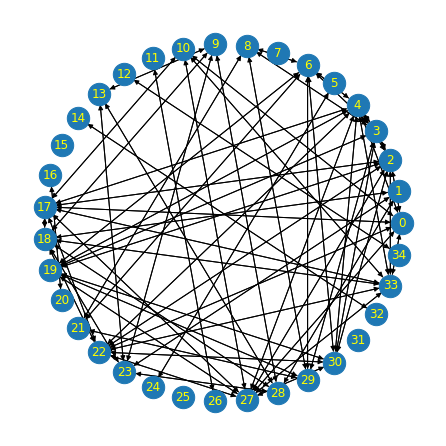

In [78]:
nx_graph = convert_jraph_to_networkx_graph(graph)
pos = nx.circular_layout(nx_graph)
plt.figure(figsize=(6, 6))
nx.draw(nx_graph, pos=pos, with_labels = True, node_size=500, font_color='yellow')

Define the GCN with the `GraphConvolution` layers we implemented:

In [79]:
def gcn_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GCN for the karate club task.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=hk.Linear(2)) # output dim is 2 because we have 2 output classes.
  graph = gn(graph)
  return graph

Training and evaluation code:

In [80]:
def optimize_club(network: hk.Transformed, num_steps: int) -> jnp.ndarray:
  """Solves the karate club problem by optimizing the assignments of students."""
  zacharys_karate_club = get_zacharys_karate_club(s_graph)
  labels = get_ground_truth_assignments_for_zacharys_karate_club(GS1d)
  params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)

  @jax.jit
  def predict(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    return jnp.argmax(decoded_graph.nodes, axis=1)

  @jax.jit
  def prediction_loss(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_graph.nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).
    return -(log_prob[0, 0] + log_prob[33, 1])

  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
    """Returns updated params and state."""
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    return jnp.mean(jnp.argmax(decoded_graph.nodes, axis=1) == labels)

  for step in range(num_steps):
    print(f"step {step} accuracy {accuracy(params).item():.2f}")
    params, opt_state = update(params, opt_state)

  return predict(params)

In [85]:
network = hk.without_apply_rng(hk.transform(gcn_definition))
result = optimize_club(network, num_steps=15)

step 0 accuracy 0.29
step 1 accuracy 0.14
step 2 accuracy 0.14
step 3 accuracy 0.09
step 4 accuracy 0.09
step 5 accuracy 0.09
step 6 accuracy 0.09
step 7 accuracy 0.09
step 8 accuracy 0.09
step 9 accuracy 0.09
step 10 accuracy 0.09
step 11 accuracy 0.09
step 12 accuracy 0.09
step 13 accuracy 0.09
step 14 accuracy 0.09


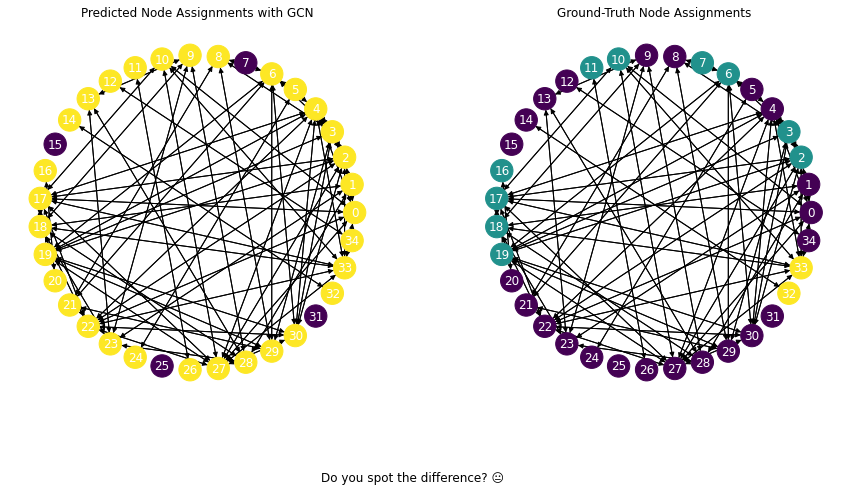

In [87]:
zacharys_karate_club = get_zacharys_karate_club(s_graph)
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GCN')

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club(GS1d)
ax2 = fig.add_subplot(122)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)

plt.show()

## Graph Attention (GAT) Layer

While the GCN we covered in the previous section can learn meaningful representations, it also has some shortcomings. Can you think of any?

In the GCN layer, the messages from all its neighbours and the node itself are equally weighted. This may lead to loss of node-specific information. E.g., consider the case when a set of nodes shares the same set of neighbors, and start out with different node features. Then because of averaging, their resulting output features would be the same. Adding self-edges mitigates this issue by a small amount, but this problem is magnified with increasing number of GCN layers and number of edges connecting to a node.

The graph attention (GAT) mechanism, as proposed by [Velickovic et al. ( 2017)](https://arxiv.org/abs/1710.10903), allows the network to learn how to weigh / assign importance to the node features from the neighbourhood when computing the new node features. This is very similar to the idea of using attention in Transformers, which were introduced in [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762).

(One could even argue that Transformers are graph attention networks operating on the special case of fully-connected graphs.)

In the figure below, $\vec{h}$ are the node features and $\vec{\alpha}$ are the learned attention weights.



<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/gat1.png" width="400px">

Figure Credit: [Velickovic et al. ( 2017)](https://arxiv.org/abs/1710.10903).
(Detail: This image is showing multi-headed attention with 3 heads, each color corresponding to a different head. At the end, an aggregation function is applied over all the heads.)

To obtain the output node features of the GAT layer, we compute:

$$ \vec{h}'_i = \sum _{j \in \mathcal{N}(i)}\alpha_{ij} \mathbf{W} \vec{h}_j$$
Here, $\mathbf{W}$ is a weight matrix which performs a linear transformation on the input.




In [88]:
# GAT implementation adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L442.
def GAT(attention_query_fn: Callable,
        attention_logit_fn: Callable,
        node_update_fn: Optional[Callable] = None,
        add_self_edges: bool = True) -> Callable:
  """Returns a method that applies a Graph Attention Network layer.

  Graph Attention message passing as described in
  https://arxiv.org/pdf/1710.10903.pdf. This model expects node features as a
  jnp.array, may use edge features for computing attention weights, and
  ignore global features. It does not support nests.
  Args:
    attention_query_fn: function that generates attention queries from sender
      node features.
    attention_logit_fn: function that converts attention queries into logits for
      softmax attention.
    node_update_fn: function that updates the aggregated messages. If None, will
      apply leaky relu and concatenate (if using multi-head attention).

  Returns:
    A function that applies a Graph Attention layer.
  """
  # pylint: disable=g-long-lambda
  if node_update_fn is None:
    # By default, apply the leaky relu and then concatenate the heads on the
    # feature axis.
    node_update_fn = lambda x: jnp.reshape(
        jax.nn.leaky_relu(x), (x.shape[0], -1))

  def _ApplyGAT(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Attention layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    # Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    # Pass nodes through the attention query function to transform
    # node features, e.g. with an MLP.
    nodes = attention_query_fn(nodes)

    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      receivers, senders = add_self_edges_fn(receivers, senders,
                                             total_num_nodes)

    # We compute the softmax logits using a function that takes the
    # embedded sender and receiver attributes.
    sent_attributes = nodes[senders]
    received_attributes = nodes[receivers]
    att_softmax_logits = attention_logit_fn(sent_attributes,
                                            received_attributes, edges)

    # Compute the attention softmax weights on the entire tree.
    att_weights = jraph.segment_softmax(
        att_softmax_logits, segment_ids=receivers, num_segments=sum_n_node)

    # Apply attention weights.
    messages = sent_attributes * att_weights
    # Aggregate messages to nodes.
    nodes = jax.ops.segment_sum(messages, receivers, num_segments=sum_n_node)

    # Apply an update function to the aggregated messages.
    nodes = node_update_fn(nodes)

    return graph._replace(nodes=nodes)

  # pylint: enable=g-long-lambda
  return _ApplyGAT

#### Test GAT Layer

### Train GAT Model on Karate Club Dataset
We will now repeat the karate club experiment with a GAT network.

In [94]:
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GAT network for the karate club node classification task.

  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """

  def _attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                          edges: jnp.ndarray) -> jnp.ndarray:
    del edges
    x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
    return hk.Linear(1)(x)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=None,
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn=lambda n: hk.Linear(8)(n),
      attention_logit_fn=_attention_logit_fn,
      node_update_fn=hk.Linear(2),
      add_self_edges=True)
  graph = gn(graph)
  return graph

Let's train the model!

We expect the model to reach an accuracy of about 0.97.

In [95]:
network = hk.without_apply_rng(hk.transform(gat_definition))
result = optimize_club(network, num_steps=15)

step 0 accuracy 0.66
step 1 accuracy 0.34
step 2 accuracy 0.31
step 3 accuracy 0.31
step 4 accuracy 0.51
step 5 accuracy 0.51
step 6 accuracy 0.51
step 7 accuracy 0.37
step 8 accuracy 0.37
step 9 accuracy 0.26
step 10 accuracy 0.26
step 11 accuracy 0.20
step 12 accuracy 0.23
step 13 accuracy 0.23
step 14 accuracy 0.23


The final node assignment predicted by the trained model:

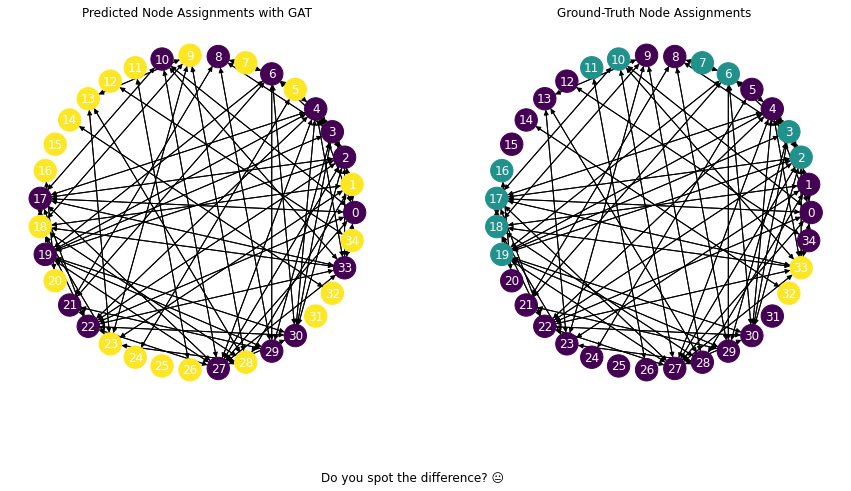

In [99]:
zacharys_karate_club = get_zacharys_karate_club(s_graph)
nx_graph = convert_jraph_to_networkx_graph(zacharys_karate_club)
pos = nx.circular_layout(nx_graph)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=result.tolist(),
    font_color='white')
ax1.title.set_text('Predicted Node Assignments with GAT')

gt_labels = get_ground_truth_assignments_for_zacharys_karate_club(GS1d)
ax2 = fig.add_subplot(122)
nx.draw(
    nx_graph,
    pos=pos,
    with_labels=True,
    node_size=500,
    node_color=gt_labels.tolist(),
    font_color='white')
ax2.title.set_text('Ground-Truth Node Assignments')
fig.suptitle('Do you spot the difference? 😐', y=-0.01)
plt.show()